In [2]:
import numpy as np
import json
import my_plt
import importlib
import pkg_resources

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

from os import path, makedirs
from glob import glob
from collections import defaultdict
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib_venn import venn3, venn3_circles

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
# from adjustText import adjust_text

makedirs("figures", exist_ok=True)

In [1]:
def calculate_cpm(input_df):
    total_count = np.sum(input_df)
    scaling_factor = 1e6 / total_count
    cpm_values = input_df * scaling_factor
    return cpm_values


def calculate_tpm(input_df, gene_lengths):
    if (list(gene_lengths.keys()) == input_df.index).sum() != len(input_df):
        raise ValueError("Genes don't match")
    rpks = input_df.divide(list(gene_lengths.values()), axis=0)
    tpm_values = rpks / (np.sum(rpks, axis=0) / 1e6)
    return tpm_values


def parse_gene_gtf(gtf_file):
    gene_lengths = {}
    with open(gtf_file, "r") as f:
        for line in f:
            line = line.strip().split()
            gene_id = line[9][1:-2]
            start = int(line[3])
            end = int(line[4])
            gene_length = end - start
            gene_lengths[gene_id] = gene_length
    return gene_lengths


def parse_exon_gtf(gtf_file):
    exon_counts = defaultdict(int)
    exon_lengths = defaultdict(list)
    exon_min_lengths, exon_max_lengths = {}, {}
    with open(gtf_file, "r") as f:
        for line in f:
            line = line.strip().split()
            gene_id = line[9][1:-2]
            start = int(line[3])
            end = int(line[4])
            exon_length = end - start
            exon_lengths[gene_id].append(exon_length)
            exon_counts[gene_id] += 1
    for gid, exon_lens in exon_lengths.items():
        exon_min_lengths[gid] = min(exon_lens)
        exon_max_lengths[gid] = max(exon_lens)        
    return exon_counts, exon_min_lengths, exon_max_lengths


# from https://github.com/mousepixels/sanbomics/blob/master/sanbomics/tools.py
class id_map(object):
    '''
    initialize the id mapping object
    
    species : string
        required. Name of species: human or mouse
        
    key: string (default: ensembl)
        The id type you are using as input keys.
        Options: symbol, ensembl, entrez
    
    target : string (default: symbol)
        The id type you want returned.
        Options: symbol, ensembl, entrez
        
    '''
    
    
    def __init__(self, species = None, key = 'ensembl', target = 'symbol'):
        
        self.key = key
        
        self.target = target
        
        self.species = species
        
        if self.species not in ['human', 'mouse']:
            raise Exception("set species to one of the following: human, mouse")
       
    
        # stream = pkg_resources.resource_stream('data/human_ids.csv')
        self.dataframe = pd.read_csv('data/human_ids.csv')
        self.dataframe = self.dataframe.rename(columns={'hgnc_symbol': 'symbol',
                                                        'ensembl_gene_id':'ensembl',
                                                        'entrezgene_id':'entrez'})
      
        
        self.mapper = self.dataframe[(self.dataframe[self.key].notna()) &\
                                     (self.dataframe[self.target].notna())]
        
        
        if target != 'entrez':
            self.mapper = dict(zip(self.mapper[self.key], self.mapper[self.target]))
        else: #because entrez is imported as floats
            self.mapper = dict(zip(self.mapper[self.key],
                                   self.mapper[self.target].map(lambda x: str(round(x)))))
            
            
    def map_column(self, df, column = None):
        '''
        map your mapping object to a pandas dataframe column.
        
        Returns a dataframe with an appended column (target + _map) containing mapped ids.
        
        df: pandas.DataFrame
        
        column: string
            Name of column containing the keys
        
        '''
        df[self.target + '_map'] = df[column].map(self.mapper)
        return df
    
    def map_list(self, l):
        '''
        Returns a mapped list with 'NA' for unmappable keys
        
        l: list
        
        '''
        def mini_mapper(x):
            try:
                return self.mapper[x]
            except:
                return 'NA'
        return [mini_mapper(x) for x in l]

In [3]:
# directories
base_dir = "/gpfs/commons/groups/gursoy_lab/cwalker/projects/pquant/workflow"
results_dir = path.join(base_dir, "results")
paper_results_dir = path.join(base_dir, "paper_results")

# gtf files
gene_gtf = "gencode.v44.basic.annotation.subset.genes_only.gtf"
exon_gtf = "gencode.v44.basic.annotation.subset.exons_only.gtf"
gene_gtf_path = path.join(base_dir, "data", "reference", "gtf", gene_gtf)
exon_gtf_path = path.join(base_dir, "data", "reference", "gtf", exon_gtf)

# test sample
tst_sample = "ENCLB059ZZZ"

# parameters
ref_prefix = "gencode.v44.basic.annotation.subset-k_20-entropy_1e-09"

gene_lengths = parse_gene_gtf(gene_gtf_path)
exon_counts, exon_min_lens, exon_max_lens = parse_exon_gtf(exon_gtf_path)

###  pQuant vs STAR vs kallisto (Figure 2a)

### Load STAR counts

In [4]:
star_count_fi = path.join(paper_results_dir, "STAR/", tst_sample, "ReadsPerGene.out.tab")

star_cols = ["gene_id", "star_count", "strand_count", "reverse_strand_count"]

star_count_df = pd.read_csv(star_count_fi, sep="\t", header=None, names=star_cols)
star_count_df = star_count_df.set_index("gene_id", drop=True)

star_features_nomap = [
    "N_unmapped",
    "N_multimapping",
    "N_noFeature",
    "N_ambiguous"
]

star_unmapped = 0

for feature in star_features_nomap:
    star_unmapped += int(star_count_df.loc[feature]["star_count"])

star_count_df.drop(star_features_nomap, axis=0, inplace=True)
star_count_df.drop(["strand_count", "reverse_strand_count"], axis=1, inplace=True)

### Load kallisto counts

In [5]:
kallisto_count_fi = path.join(paper_results_dir, "kallisto", tst_sample, "gene_counts.tsv")

kallisto_count_df = pd.read_csv(
    kallisto_count_fi,
    sep="\t",
    header=None,
    names=["gene_id", "kallisto_count"]
).set_index("gene_id", drop=True)

### Load pQuant counts

In [60]:
def parse_pquant_counts(he_fi):
    he_counts = {}
    with open(he_fi, "r") as f:
        for line in f.readlines():
            if line.startswith("ENSG"):
                line = line.strip().split(" : ")
                gene = line[0]
                count = int(line[1])
                he_counts[gene] = count
    pquant_he_df = pd.DataFrame(
        {
            "gene": list(he_counts.keys()),
            "count": list(he_counts.values())
        }
    )
    pquant_he_df = pquant_he_df.set_index("gene", drop=True)
    pquant_he_df = pquant_he_df.loc[list(kallisto_count_df.index)]
    return pquant_he_df

In [35]:
# parse HE output
he_fi = "/gpfs/commons/groups/gursoy_lab/cwalker/projects/pquant/workflow/data/reference/pQuant_enc/gencode.v44.basic.annotation.subset-k_20-entropy_1e-09/bfv/ENCLB059ZZZ/gene_counts.info"
he_counts = {}
with open(he_fi, "r") as f:
    for line in f.readlines():
        if line.startswith("ENSG"):
            line = line.strip().split(" : ")
            gene = line[0]
            count = int(line[1])
            he_counts[gene] = count

pquant_he_df = pd.DataFrame(
    {
        "gene": list(he_counts.keys()),
        "count": list(he_counts.values())
    }
)
pquant_he_df = pquant_he_df.set_index("gene", drop=True)
pquant_he_df = pquant_he_df.loc[list(kallisto_count_df.index)]


In [36]:
base_dir = f"../results/pquant_kmer_sum_paired_WITH_RC/{tst_sample}/"

entropy = 1e-07

for k in [30]:
# for sumthresh in [5]:
    # load 
    pquant_kmer_tsv = base_dir + f"{tst_sample}.k_{k}.entropy_{entropy}.counts.tsv"
    try:
        pquant_kmer_df = pd.read_csv(pquant_kmer_tsv, sep="\t", skiprows=1)
        pquant_kmer_df = pquant_kmer_df.set_index("gene_id", drop=True)
    except:
        pquant_kmer_df = pd.read_csv(pquant_kmer_tsv, sep="\t", skiprows=0)
        pquant_kmer_df = pquant_kmer_df.set_index("gene_id", drop=True)
    pquant_kmer_df = pquant_kmer_df.reindex(star_count_df.index)

    merged_count_df = pd.DataFrame(
        {
            "he_pquant_counts": list(pquant_he_df["count"]),
            "star_counts": list(star_count_df["star_count"]),
            "kallisto_counts": list(kallisto_count_df["kallisto_count"]),
            "pquant_kmer_counts": list(pquant_kmer_df["sum"])
        }
    )

    merged_count_df.index = pquant_kmer_df.index
    log_merged_count_df = np.log2(merged_count_df + 1)

    merged_cpm_df = calculate_cpm(merged_count_df)
    log_merged_cpm_df = np.log2(calculate_cpm(merged_count_df) + 1)

    merged_tpm_df = calculate_tpm(merged_count_df, gene_lengths=gene_lengths)
    log_merged_tpm_df = np.log2(calculate_tpm(merged_count_df, gene_lengths=gene_lengths) + 1)

    pquant_kmer_star_r = round(stats.pearsonr(merged_count_df["pquant_kmer_counts"], merged_count_df["star_counts"])[0])
    pquant_kmer_kallisto_r = stats.pearsonr(merged_count_df["pquant_kmer_counts"], merged_count_df["kallisto_counts"])[0]
    star_kallisto_r = stats.pearsonr(merged_count_df["star_counts"], merged_count_df["kallisto_counts"])[0]

    pquant_kmer_cpm_star_r = round(stats.pearsonr(merged_cpm_df["pquant_kmer_counts"], merged_cpm_df["star_counts"])[0])
    pquant_kmer_cpm_kallisto_r = stats.pearsonr(merged_cpm_df["pquant_kmer_counts"], merged_cpm_df["kallisto_counts"])[0]
    star_cpm_kallisto_r = stats.pearsonr(merged_cpm_df["star_counts"], merged_cpm_df["kallisto_counts"])[0]

    pquant_kmer_tpm_star_r = round(stats.pearsonr(merged_tpm_df["pquant_kmer_counts"], merged_tpm_df["star_counts"])[0])
    pquant_kmer_tpm_kallisto_r = stats.pearsonr(merged_tpm_df["pquant_kmer_counts"], merged_tpm_df["kallisto_counts"])[0]
    star_tpm_kallisto_r = stats.pearsonr(merged_tpm_df["star_counts"], merged_tpm_df["kallisto_counts"])[0]

    dfs = [
        merged_count_df,
        log_merged_count_df,
        merged_cpm_df,\
        log_merged_cpm_df,
        merged_tpm_df,
        log_merged_tpm_df
    ]


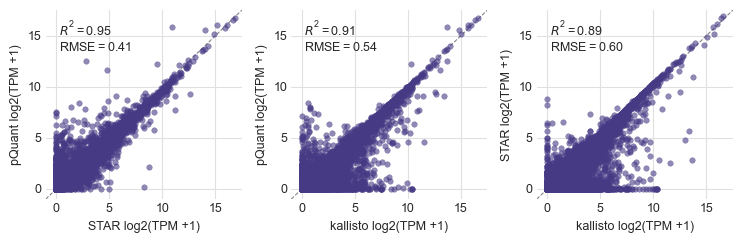

In [120]:
importlib.reload(my_plt)

fig, ax = plt.subplots(1, 3, figsize=(7.5,2.5))

df = log_merged_tpm_df

scatter_col = my_plt.deep_sey_palette["boozy_purple"]

lower_xlims = [
    -50,
    -.5,
    -200,
    -.5,
    -1000,
    -.5
]

upper_xlims = [
    2200,
    12,
    13000,
    14,
    45000,
    16
]

anno_x = 0.066
anno_y = 0.955

lower_lim = -1
upper_lim = 20

ms = 16
line_col = "black"
alpha=.6

sns.scatterplot(
    data=df,
    x="star_counts",
    y="he_pquant_counts",
    ax=ax[0],
    color=scatter_col,
    s=ms,
    edgecolor=scatter_col,
    alpha=alpha,
    zorder=5
)
ax[0].set_ylabel(f"pQuant log2(TPM +1)")
ax[0].set_xlabel(f"STAR log2(TPM +1)")
# ax[0].set_xlim(left=lower_xlims[i], right=upper_xlims[i])

r2 = r2_score(df["star_counts"], df["he_pquant_counts"])
rmse = mean_squared_error(df["star_counts"], df["he_pquant_counts"], squared=False)

ax[0].text(
    anno_x,
    anno_y,
    r'$\mathit{R}^2=$' + f"{r2:.2f}\n" + "RMSE$=$" + f"{rmse:.2f}",
    transform=ax[0].transAxes,
    va='top', 
    ha='left'
)

sns.scatterplot(
    data=df,
    x="kallisto_counts",
    y="he_pquant_counts",
    ax=ax[1],
    color=scatter_col,
    s=ms,
    edgecolor=scatter_col,
    alpha=alpha,
    zorder=5
)
ax[1].set_ylabel(f"pQuant log2(TPM +1)")
ax[1].set_xlabel(f"kallisto log2(TPM +1)")
# ax[1].set_xlim(left=lower_xlims[i], right=upper_xlims[i])

r2 = r2_score(df["kallisto_counts"], df["he_pquant_counts"])
rmse = mean_squared_error(df["kallisto_counts"], df["he_pquant_counts"], squared=False)

ax[1].text(
    anno_x,
    anno_y,
    r'$\mathit{R}^2=$' + f"{r2:.2f}\n" + "RMSE$=$" + f"{rmse:.2f}",
    transform=ax[1].transAxes,
    va='top', 
    ha='left'
)


sns.scatterplot(
    data=df,
    x="kallisto_counts",
    y="star_counts",
    ax=ax[2],
    color=scatter_col,
    s=ms,
    edgecolor=scatter_col,
    alpha=alpha,
    zorder=5
)

ax[2].set_ylabel(f"STAR log2(TPM +1)")
ax[2].set_xlabel(f"kallisto log2(TPM +1)")
# ax[2].set_ylim(lower_lim, upper_lim)
# ax[2].set_xlim(lower_lim, upper_lim)

r2 = r2_score(df["kallisto_counts"], df["star_counts"])
rmse = mean_squared_error(df["kallisto_counts"], df["star_counts"], squared=False)

ax[2].text(
    anno_x,
    anno_y,
    r'$\mathit{R}^2=$' + f"{r2:.2f}\n" + "RMSE$=$" + f"{rmse:.2f}",
    transform=ax[2].transAxes,
    va='top',
    ha='left'
)

upper_lim=17.5

for i in [0,1,2]:
    ax[i].set_xticks([0, 5, 10, 15, 20])
    ax[i].set_yticks([0, 5, 10, 15, 20])
    ax[i].set_ylim(lower_lim, upper_lim)
    ax[i].set_xlim(lower_lim, upper_lim)
    my_plt.style_scatterplot(ax=ax[i], xy_line=True)



fig.tight_layout()

plt.savefig(
    "figures/pQuant_vs_star_and_kallisto_scatters.pdf",
    format="pdf",
    facecolor="white",
    bbox_inches="tight"
)

### Run time and memory per gene (Figure 3a, 3b)

In [4]:
def get_time_and_memory_per_gene_from_step_four_log(batch_out_fi):
    with open(batch_out_fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]

    # get memory
    memory_line = [element for element in lines if element.startswith("Memory usage")][0]
    equal_index = memory_line.index('=')
    open_parenthesis_index = memory_line.index('GB')
    memory_usage_mb = int(((float(memory_line[equal_index + 1:open_parenthesis_index].strip())) / 200) * 1000)

    # get total time
    time_line = [element for element in lines if element.startswith("total duration")][0]
    total_minutes = (int(time_line.split(" ")[3]) / 60000) / 200
    return memory_usage_mb, total_minutes


batch_dir = path.join(base_dir, "data", "reference", "pQuant_enc", ref_prefix, "bfv", tst_sample, "batches")
batch_log_dir = path.join(base_dir, "logs", "pQuant_enc_step_four")

step_four_prefix = "reference_gencode.v44.basic.annotation.subset.sample_ENCLB059ZZZ.k_20.entropy_1e-09."

mems_per_gene = []
times_per_gene = []

for batch_fi in glob(path.join(batch_dir, "*")):
    batch_id = batch_fi.split("/")[-1].split(".")[0]
    batch_out_fi = path.join(batch_log_dir, step_four_prefix + batch_id + ".out")

    mem, time = get_time_and_memory_per_gene_from_step_four_log(batch_out_fi)
    mems_per_gene.append(mem)
    times_per_gene.append(time)

In [5]:
bfv_dir = path.join(base_dir, "data", "reference", "pQuant_enc", ref_prefix, "bfv")

subsamples = [
    20000000,
    30000000,
    40000000,
    50000000
]

mems_per_gene = defaultdict(list)
times_per_gene = defaultdict(list)

for ss in subsamples:
    sample_subsample = f"ENCLB059ZZZ.n_{ss}"
    batch_dir = path.join(bfv_dir, sample_subsample, "batches")
    batch_log_dir = path.join(base_dir, "logs", "pQuant_enc_step_four")

    step_four_prefix = f"reference_gencode.v44.basic.annotation.subset.sample_ENCLB059ZZZ.n_{ss}.k_20.entropy_1e-09."

    for batch_fi in glob(path.join(batch_dir, "*")):
        batch_id = batch_fi.split("/")[-1].split(".")[0]
        batch_out_fi = path.join(batch_log_dir, step_four_prefix + batch_id + ".out")

        mem, time = get_time_and_memory_per_gene_from_step_four_log(batch_out_fi)
        mems_per_gene[ss].append(mem)
        times_per_gene[ss].append(time)

time_per_gene_df = pd.DataFrame(times_per_gene).melt()
time_per_gene_df.columns = ["subsample_n", "time_per_gene"]

In [6]:
subsample_label_map = {
    20000000: r"$2\times10^7$",
    30000000: r"$3\times10^7$",
    40000000: r"$4\times10^7$",
    50000000: r"$5\times10^7$",
}

In [7]:
time_per_gene_df['subsample_n'] = time_per_gene_df['subsample_n'].map(subsample_label_map)

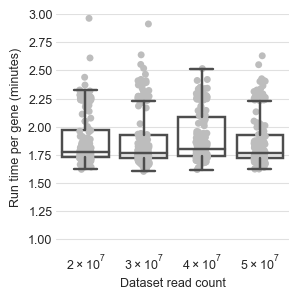

In [9]:
importlib.reload(my_plt)

fig, ax = plt.subplots(figsize=(3,3))

my_plt.style_vboxplot(ax)


time_per_gene_color = "#bdbdbd"

sns.stripplot(
    data=time_per_gene_df,
    x="subsample_n",
    y="time_per_gene",
    color=time_per_gene_color,
    # alpha=.5,
    # zorder=0
)
boxplot=sns.boxplot(
    data=time_per_gene_df,
    x="subsample_n",
    y="time_per_gene",
    showfliers=False,
    color="grey",
    boxprops=dict(facecolor='none'),
    zorder=50
)

ax.set_xlabel("Dataset read count")
ax.set_ylabel("Run time per gene (minutes)")

ax.set_ylim(0.99,3)

plt.savefig(
    "figures/pQuant_run_time_per_gene_by_read_count.pdf",
    format="pdf",
    facecolor="white",
    bbox_inches="tight"
)

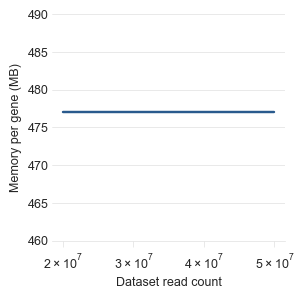

In [10]:
mem_per_gene_single_value = int(list(set(pd.DataFrame(mems_per_gene).melt()["value"]))[0])

fig, ax = plt.subplots(figsize=(3,3))

sns.lineplot(
    subsample_label_map.values(),
    [mem_per_gene_single_value] * len(subsamples),
    color=my_plt.deep_sey_palette["darker_blue"]
)

ax.set_ylim(460,490)

my_plt.style_lineplot(ax)

ax.set_ylabel("Memory per gene (MB)")
ax.set_xlabel("Dataset read count")

plt.savefig(
    "figures/pQuant_memory_per_gene_by_read_count.pdf",
    format="pdf",
    facecolor="white",
    bbox_inches="tight"
)

### Differential expression analysis (Figure 2b)

In [11]:
def parse_pquant_counts(he_fi, shared_gene_index):
    he_counts = {}
    with open(he_fi, "r") as f:
        for line in f.readlines():
            if line.startswith("ENSG"):
                line = line.strip().split(" : ")
                gene = line[0]
                count = int(line[1])
                he_counts[gene] = count
    pquant_he_df = pd.DataFrame(
        {
            "gene": list(he_counts.keys()),
            "pquant_count": list(he_counts.values())
        }
    )
    pquant_he_df = pquant_he_df.set_index("gene", drop=True)
    pquant_he_df = pquant_he_df.loc[shared_gene_index]
    return pquant_he_df
    

def parse_star_counts(count_fi, fixed_index=None):
    star_cols = ["gene_id", "star_count", "strand_count", "reverse_strand_count"]
    star_count_df = pd.read_csv(
        count_fi, sep="\t", header=None, names=star_cols, skiprows=4
    )
    star_count_df = star_count_df.set_index("gene_id", drop=True)
    star_count_df.drop(["strand_count", "reverse_strand_count"], axis=1, inplace=True)
    if fixed_index:
        star_count_df = star_count_df.reindex(fixed_index)
    return star_count_df


def parse_kallisto_counts(count_fi, fixed_index=None):
    kallisto_count_df = pd.read_csv(
        count_fi,
        sep="\t",
        header=None,
        names=["gene_id", "kallisto_count"]
    ).set_index("gene_id", drop=True)
    if fixed_index:
        kallisto_count_df = kallisto_count_df.reindex(fixed_index)
    return kallisto_count_df

#### Parse sample info

In [16]:
sample_file = "../data/encode/pe_differential_expression_samples/pancreas_esophagus_sample_notes.csv"

sample_df = pd.read_csv(sample_file)
sample_df = sample_df[sample_df["pair"] == 1]

conditions = list(set(sample_df["experiment"]))

sample_conditions = {}
for cond in conditions:
    df = sample_df[sample_df["experiment"] == cond]
    sample_conditions[cond] = df["accession"].tolist()

samples = sample_df["accession"].tolist()

metadata = pd.DataFrame.from_dict(sample_conditions, orient='index').stack()
metadata = metadata.reset_index(level=1, drop=True).reset_index(name='value')
metadata.columns = ["condition", "sample"]
metadata = metadata.set_index("sample")

#### Define data directories

In [18]:
star_data_dir = "../paper_results/STAR"
kallisto_data_dir = "../paper_results/kallisto"
pquant_data_dir = "../data/reference/pQuant_enc/gencode.v44.basic.annotation.subset-k_20-entropy_1e-09/bfv"

#### Parse results

In [19]:
star_count_dic = {}
kallisto_count_dic = {}
pquant_count_dic = {}
pquant_k_entropy_count_dic = {}

star_count_fi = path.join(star_data_dir, samples[0], "ReadsPerGene.out.tab")
fixed_index = parse_star_counts(star_count_fi).index.tolist()

for sample in samples:
    # load STAR counts
    star_count_fi = path.join(star_data_dir, sample, "ReadsPerGene.out.tab")
    star_counts = parse_star_counts(star_count_fi, fixed_index=fixed_index)
    star_count_dic[sample] = star_counts["star_count"].tolist()

    # load kallisto counts
    kallisto_count_fi = path.join(kallisto_data_dir, sample, "gene_counts.tsv")
    kallisto_counts = parse_kallisto_counts(kallisto_count_fi, fixed_index=fixed_index)
    kallisto_count_dic[sample] = kallisto_counts["kallisto_count"].tolist()

    # load pQuant counts
    pquant_count_fi = path.join(pquant_data_dir, sample, "gene_counts.info")
    pquant_counts = parse_pquant_counts(pquant_count_fi, fixed_index)
    pquant_count_dic[sample] = pquant_counts["pquant_count"].tolist()

# convert count dics to dfs and remove 0s
star_count_df = pd.DataFrame(star_count_dic, index=fixed_index)
kallisto_count_df = pd.DataFrame(kallisto_count_dic, index=fixed_index)
pquant_count_df = pd.DataFrame(pquant_count_dic, index=fixed_index)

star_count_df = star_count_df[star_count_df.sum(axis=1) > 0].T
kallisto_count_df = kallisto_count_df[kallisto_count_df.sum(axis=1) > 0].T
kallisto_count_df = kallisto_count_df.round().astype(int)
pquant_count_df = pquant_count_df[pquant_count_df.sum(axis=1) > 0].T

In [20]:
metadata = metadata.loc[star_count_df.index]

#### Create deseq datasets

In [21]:
print("Processing STAR")
star_dds = DeseqDataSet(
    counts=star_count_df,
    clinical=metadata,
    design_factors="condition"
    
)
print("Processing kallisto")
kallisto_dds = DeseqDataSet(
    counts=kallisto_count_df,
    clinical=metadata,
    design_factors="condition"
)
print("Processing pQuant")
pquant_dds = DeseqDataSet(
    counts=pquant_count_df,
    clinical=metadata,
    design_factors="condition"
)

Processing STAR
Processing kallisto
Processing pQuant


#### Fit models

In [22]:
star_dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 61.20 seconds.

Fitting dispersion trend curve...
... done in 21.91 seconds.

Fitting MAP dispersions...
... done in 67.19 seconds.

Fitting LFCs...
... done in 44.65 seconds.

Refitting 4 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [23]:
kallisto_dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 70.87 seconds.

Fitting dispersion trend curve...
... done in 24.51 seconds.

Fitting MAP dispersions...


/gpfs/commons/groups/gursoy_lab/cwalker/tools/miniconda3/envs/jup/lib/python3.10/site-packages/pydeseq2/dds.py:521: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/gpfs/commons/groups/gursoy_lab/cwalker/tools/miniconda3/envs/jup/lib/python3.10/site-packages/numpy/lib/utils.py:1119: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan
/gpfs/commons/groups/gursoy_lab/cwalker/tools/miniconda3/envs/jup/lib/python3.10/site-packages/pydeseq2/utils.py:607: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/gpfs/commons/groups/gursoy_lab/cwalker/tools/miniconda3/envs/jup/lib/python3.10/site-packages/pydeseq2/utils.py:648: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/gpfs/commons/groups/gursoy_lab/cwalker/tools/miniconda3/envs/jup/lib/python3.10/site-packages/numpy/linalg/linalg.py:2079: Runt

... done in 76.75 seconds.

Fitting LFCs...
... done in 48.66 seconds.

Refitting 30 outliers.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.14 seconds.

Fitting LFCs...
... done in 0.21 seconds.



In [24]:
pquant_dds.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 88.94 seconds.

Fitting dispersion trend curve...
... done in 27.06 seconds.

Fitting MAP dispersions...
... done in 114.88 seconds.

Fitting LFCs...
... done in 52.40 seconds.

Refitting 991 outliers.

Fitting dispersions...
... done in 3.33 seconds.

Fitting MAP dispersions...
... done in 3.45 seconds.

Fitting LFCs...
... done in 3.08 seconds.



#### Generate results dataframes

In [27]:
mapper = id_map(species = 'human')

In [28]:
condition_a = "ENCSR629VMZ"
condition_b = "ENCSR102TQN"

In [ ]:
star_stat_res = DeseqStats(
    star_dds, n_cpus=8, contrast = (
        "condition", condition_a, condition_b
    )
)
star_stat_res.summary()

star_res = star_stat_res.results_df
star_res["index_no_period"] = [i.split(".")[0] for i in star_res.index.tolist()]
star_res["gene_id"] = star_res["index_no_period"].map(mapper.mapper)
star_res = star_res[star_res["baseMean"] >= 5]
star_res["nlog10"] = -np.log10(star_res["padj"])
star_res = star_res.dropna(subset=['pvalue', 'padj', 'nlog10', "log2FoldChange"], how='all')

In [ ]:
kallisto_stat_res = DeseqStats(
    kallisto_dds, n_cpus=8, contrast = (
        "condition", condition_a, condition_b
    )
)
kallisto_stat_res.summary()

kallisto_res = kallisto_stat_res.results_df
kallisto_res["index_no_period"] = [i.split(".")[0] for i in kallisto_res.index.tolist()]
kallisto_res["gene_id"] = kallisto_res["index_no_period"].map(mapper.mapper)
kallisto_res = kallisto_res[kallisto_res["baseMean"] >= 5]
kallisto_res["nlog10"] = -np.log10(kallisto_res["padj"])
kallisto_res = kallisto_res.dropna(subset=['pvalue', 'padj', 'nlog10', "log2FoldChange"], how='all')

In [ ]:
pquant_stat_res = DeseqStats(
    pquant_dds, n_cpus=8, contrast = (
        "condition", condition_a, condition_b
    )
)
pquant_stat_res.summary()

pquant_res = pquant_stat_res.results_df
pquant_res["index_no_period"] = [i.split(".")[0] for i in pquant_res.index.tolist()]
pquant_res["gene_id"] = pquant_res["index_no_period"].map(mapper.mapper)
pquant_res = pquant_res[pquant_res["baseMean"] >= 5]
pquant_res["nlog10"] = -np.log10(pquant_res["padj"])
pquant_res = pquant_res.dropna(subset=['pvalue', 'padj', 'nlog10'], how='all')

In [ ]:
log2_threshold = 2
nlog10_threshold = 10

star_sig_genes = set(star_res[(abs(star_res["log2FoldChange"]) > log2_threshold) & (star_res["nlog10"] > nlog10_threshold)].index)
kallisto_sig_genes = set(kallisto_res[(abs(kallisto_res["log2FoldChange"]) > log2_threshold) & (kallisto_res["nlog10"] > nlog10_threshold)].index)
pquant_sig_genes = set(pquant_res[(abs(pquant_res["log2FoldChange"]) > log2_threshold) & (pquant_res["nlog10"] > nlog10_threshold)].index)

star_sig_genes_unique = list(star_sig_genes - (kallisto_sig_genes | pquant_sig_genes))
kallisto_sig_genes_unique = list(kallisto_sig_genes - (star_sig_genes | pquant_sig_genes))
pquant_sig_genes_unique = list(pquant_sig_genes - (kallisto_sig_genes| star_sig_genes))

all_sig_genes = star_sig_genes & kallisto_sig_genes & pquant_sig_genes
star_pquant_sig_genes = star_sig_genes & pquant_sig_genes
star_kallisto_sig_genes = star_sig_genes & kallisto_sig_genes
kallisto_pquant_sig_genes = kallisto_sig_genes & pquant_sig_genes
len(all_sig_genes), len(star_sig_genes_unique), len(kallisto_sig_genes_unique), len(pquant_sig_genes_unique)

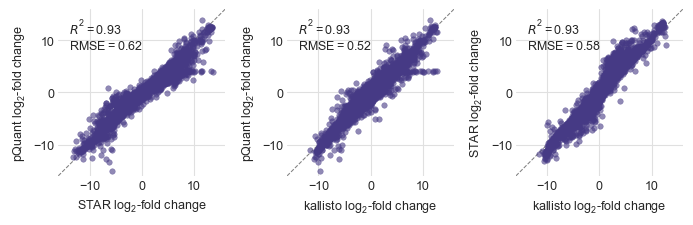

In [36]:
import importlib
importlib.reload(my_plt)

res_dfs = {
    "STAR": star_res,
    "kallisto": kallisto_res,
    "pQuant": pquant_res
}

fig, ax = plt.subplots(1, 3, figsize=(7,2.33))
scatter_col = my_plt.deep_sey_palette["boozy_purple"]

anno_x = 0.066
anno_y = 0.955

alpha = 0.6
ms = 16

ax_i = 0

for pair in [["STAR", "pQuant"], ["kallisto", "pQuant"], ["kallisto", "STAR"]]:
    # fig, ax = plt.subplots(figsize=(3,3))

    df1, df2 = res_dfs[pair[0]], res_dfs[pair[1]]

    # Find shared indices between the two dataframes
    shared_indices = df1.index.intersection(df2.index)

    # Filter both dataframes to retain only shared rows
    filtered_df1 = df1.loc[shared_indices]
    filtered_df2 = df2.loc[shared_indices]

    # Ensure both dataframes have the same row order (this step might be redundant, but it's good for clarity)
    assert all(filtered_df1.index == filtered_df2.index), "Indices between dataframes do not match!"

    # Extract 'pvalue' columns from both dataframes
    x_values = filtered_df1['log2FoldChange']
    y_values = filtered_df2['log2FoldChange']

    # Create the scatter plot
    sns.scatterplot(
        x=x_values,
        y=y_values,
        ax=ax[ax_i],
        color=scatter_col,
        s=ms,
        edgecolor=scatter_col,
        alpha=alpha,
        zorder=5
    )
    ax[ax_i].set_xlabel(f'{pair[0]} log$_2$-fold change')
    ax[ax_i].set_ylabel(f'{pair[1]} log$_2$-fold change')
    # plt.title('Scatter plot of pvalues')

    r2 = r2_score(x_values, y_values)
    rmse = mean_squared_error(x_values, y_values, squared=False)

    ax[ax_i].text(
        anno_x,
        anno_y,
        r'$\mathit{R}^2=$' + f"{r2:.2f}\n" + "RMSE$=$" + f"{rmse:.2f}",
        transform=ax[ax_i].transAxes,
        va='top',
        ha='left'
    )

    my_plt.style_scatterplot(ax[ax_i], xy_line=True)
    ax[ax_i].set_xlim(-16,16)
    ax[ax_i].set_ylim(-16,16)
    ax_i += 1


fig.tight_layout()

# plt.savefig(
#     "figures/DE_log2_fold_change_comparisons.pdf",
#     format="pdf",
#     facecolor="white",
#     bbox_inches="tight"
# )